### Analyses code

### Sanittawan Tan

In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# import warnings
# warnings.filterwarnings('ignore')

### Data preparation

In [2]:
prelim_dtype = {'year': 'Int64', 'country': 'str', 'Status': 'str'}
dem = pd.read_csv('./democracy.csv', dtype=prelim_dtype)

In [3]:
dem['year'] = pd.to_datetime(dem['year'], format='%Y').dt.year

In [4]:
dem[:15]

,country,year,PR,CL,Status,FH_category,FH_F,FH_NF,FH_PF,BMR_democracy,...,v2elpubfin_ord,v2elembaut_ord,v2elmulpar_ord,v2elvotbuy_ord,v2elfrcamp_ord,v2elfrfair_ord,v2elaccept_ord,v2elasmoff_ord,v2elintim,is_erosion
0,afghanistan,2000,7,7,NF,0,0,1,0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,afghanistan,2001,7,7,NF,0,0,1,0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,afghanistan,2002,6,6,NF,0,0,1,0,0.0,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,afghanistan,2003,6,6,NF,0,0,1,0,0.0,...,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,afghanistan,2004,5,6,NF,0,0,1,0,0.0,...,0.0,2.0,2.0,1.0,2.0,2.0,3.0,2.0,-0.240,0
5,afghanistan,2005,5,5,PF,1,0,0,1,0.0,...,0.0,2.0,3.0,1.0,2.0,2.0,3.0,2.0,-0.240,0
6,afghanistan,2006,5,5,PF,1,0,0,1,0.0,...,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
7,afghanistan,2007,5,5,PF,1,0,0,1,0.0,...,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
8,afghanistan,2008,5,6,NF,0,0,1,0,0.0,...,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9,afghanistan,2009,6,6,NF,0,0,1,0,0.0,...,0.0,2.0,3.0,0.0,2.0,2.0,3.0,2.0,-0.421,0


In [5]:
# current shape
dem.shape

(3478, 76)

In [6]:
nominal = ['v2lgfunds_ord', 'v2lgamend',
            'v2exhoshog', 'v2exaphogp', 'v2exaphos', 'v2ddlexci',
            'v2ddlexrf', 'v2ddlexpl'
]

In [7]:
count = 0
for col in nominal:
    uniq_val = len(dem[col].unique())
    print(uniq_val)
    count += uniq_val

3
3
3
3
3
4
4
4


In [8]:
for col in nominal:
    pref = col + '_'
    cols_to_concat = pd.get_dummies(dem[col], prefix=pref, drop_first=True)
    dem = pd.concat([dem, cols_to_concat], axis=1)
    dem.drop(columns=[col], inplace=True)

In [9]:
# new shape
dem.shape

(3478, 79)

In [10]:
dem.describe()

,year,PR,CL,FH_category,FH_F,FH_NF,FH_PF,BMR_democracy,BMR_democracy_trans,BMR_democracy_breakdowns,...,v2lgamend__1.0,v2exhoshog__1.0,v2exaphogp__1.0,v2exaphos__1.0,v2ddlexci__1.0,v2ddlexci__2.0,v2ddlexrf__1.0,v2ddlexrf__2.0,v2ddlexpl__1.0,v2ddlexpl__2.0
count,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3083.000000,3083.000000,3041.000000,...,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000
mean,2008.543416,3.368603,3.284359,1.209603,0.454859,0.245256,0.299885,0.594226,0.002919,0.410720,...,0.418919,0.309373,0.324899,0.025589,0.031052,0.137148,0.011213,0.106958,0.073893,0.503738
std,5.186123,2.158079,1.853552,0.810167,0.498030,0.430301,0.458273,0.491121,0.103435,0.767774,...,0.493453,0.462302,0.468405,0.157930,0.173484,0.344053,0.105313,0.309104,0.261634,0.500058
min,2000.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2004.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2009.000000,3.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2013.000000,6.000000,5.000000,2.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2017.000000,7.000000,7.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
dem['FH_category'].value_counts()

2    1582
1    1043
0     853
Name: FH_category, dtype: int64

**We detect class imbalance problem here!**

In [12]:
dem['is_erosion'].value_counts()

0    3081
1     397
Name: is_erosion, dtype: int64

In [14]:
imbalance = dem['is_erosion'].value_counts()

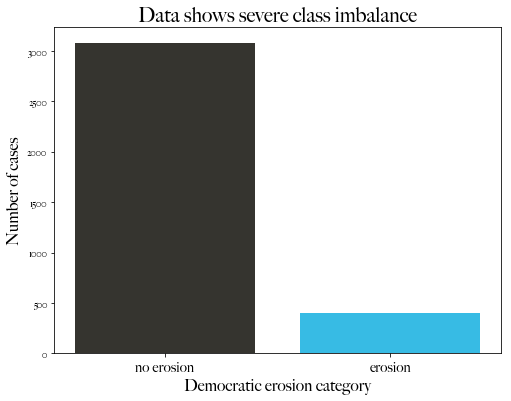

In [16]:
plt.figure(figsize=(8, 6))
plt.bar(x=np.arange(2), height=imbalance.values, color=['#35342f', '#37bbe4'])
plt.yticks(fontfamily='Big Caslon')
plt.xticks(np.arange(2), ["no erosion", "erosion"], fontfamily='Big Caslon', fontsize=14)
plt.xlabel('Democratic erosion category', fontfamily='Big Caslon', fontsize=16)
plt.ylabel('Number of cases', fontfamily='Big Caslon', fontsize=16)
plt.title('Data shows severe class imbalance', fontname='Big Caslon', fontsize=20)
plt.savefig('class_imbalance.png', dpi=300, bbox_inches='tight');

In [22]:
len(dem['country'].unique())

195

In [23]:
len(dem['country'].unique()) * 18

3510

### Dealing with missingness
* visualization tutorial: https://dev.to/tomoyukiaota/visualizing-the-patterns-of-missing-value-occurrence-with-python-46dj

In [195]:
dem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3478 entries, 0 to 3477
Data columns (total 79 columns):
country                     3478 non-null object
year                        3478 non-null int64
PR                          3478 non-null int64
CL                          3478 non-null int64
Status                      3478 non-null object
FH_category                 3478 non-null int64
FH_F                        3478 non-null int64
FH_NF                       3478 non-null int64
FH_PF                       3478 non-null int64
BMR_democracy               3083 non-null float64
BMR_democracy_trans         3083 non-null float64
BMR_democracy_breakdowns    3041 non-null float64
BMR_democracy_duration      3083 non-null float64
v2lginello                  3037 non-null float64
v2lginelup                  1253 non-null float64
v2exl_legitlead_ord         2939 non-null float64
v2pepwrgeo_ord              2955 non-null float64
v2clgencl_ord               2958 non-null float64
v2clpolcl

In [196]:
from matplotlib.colors import ListedColormap
#https://stackoverflow.com/questions/33918822/map-value-to-specific-colour-in-seaborn-heatmap

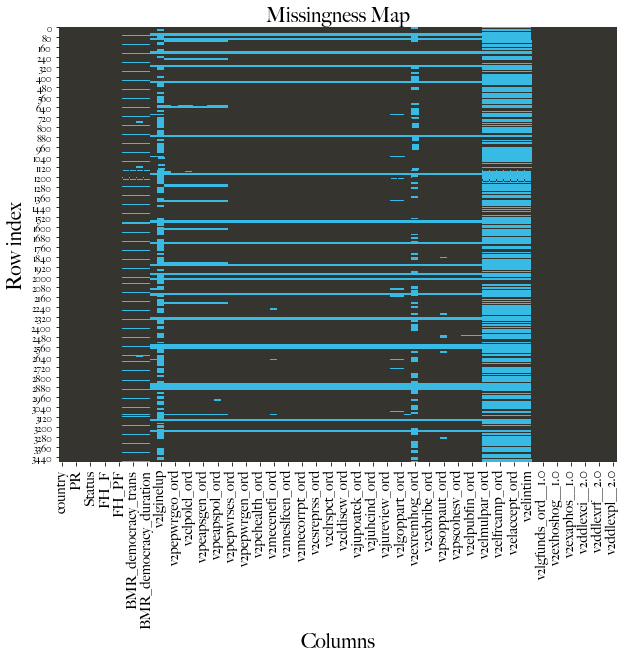

In [198]:
plt.figure(figsize=(10,8))
sns.heatmap(dem.isnull(), cbar=False,  cmap=ListedColormap(['#35342f', '#37bbe4']))
plt.yticks(fontfamily='Big Caslon')
plt.xticks(fontfamily='Big Caslon', fontsize=14)
plt.xlabel('Columns', fontfamily='Big Caslon', fontsize=20)
plt.ylabel('Row index', fontfamily='Big Caslon', fontsize=20)
plt.title('Missingness Map', fontname='Big Caslon', fontsize=20)
plt.savefig('missings_map.png', dpi=300, bbox_inches='tight');

**Drop columns with a lot of missing data**

In [200]:
# drop columns with a lot of missingness
cols_to_drop_missing = ['v2elmulpar_ord',
'v2elvotbuy_ord',
'v2elfrcamp_ord',
'v2elfrfair_ord',
'v2elaccept_ord',
'v2elasmoff_ord',
'v2elintim',
'v2lginelup']

dem.drop(columns=cols_to_drop_missing, inplace=True)

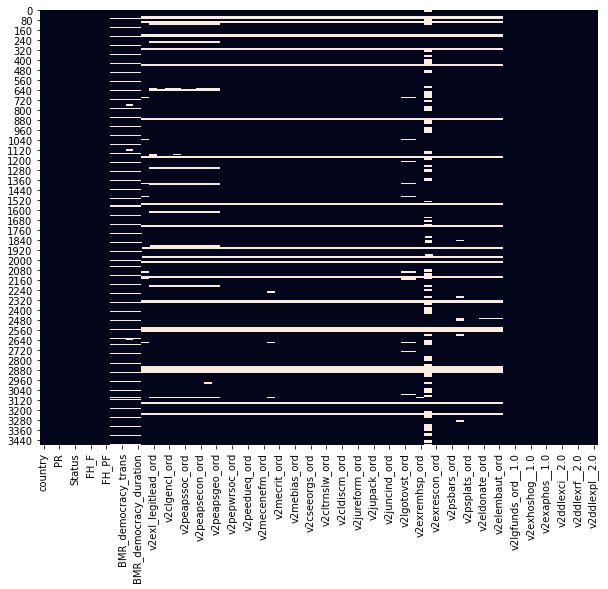

In [16]:
# reevaluate
plt.figure(figsize=(10,8))
sns.heatmap(dem.isnull(), cbar=False);

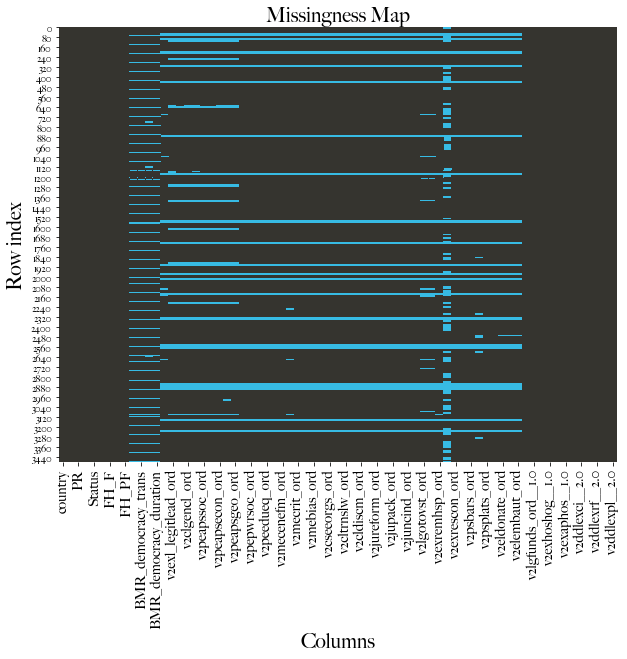

In [201]:
plt.figure(figsize=(10,8))
sns.heatmap(dem.isnull(), cbar=False,  cmap=ListedColormap(['#35342f', '#37bbe4']))
plt.yticks(fontfamily='Big Caslon')
plt.xticks(fontfamily='Big Caslon', fontsize=14)
plt.xlabel('Columns', fontfamily='Big Caslon', fontsize=20)
plt.ylabel('Row index', fontfamily='Big Caslon', fontsize=20)
plt.title('Missingness Map', fontname='Big Caslon', fontsize=20)
plt.savefig('after_missings_map.png', dpi=300, bbox_inches='tight');

### Predicting whether a country is experiencing/has experienced democratic erosion

#### Selecting dependent and independent variables
* dependent variable of interest = 'is_erosion' (Derived from Freedom House's 'Partly Free' status. If a country is classified by the Freedom House as partly free, that country-year experiences democratic erosion)
    * 0 = No erosion
    * 1 = Is experiencing or has experienced erosion
* independent variables = all others except for some variables lagged by 3 years

In [203]:
PERIODS = 3

In [204]:
dependent_var = set(['country', 'year', 'is_erosion'])
dep_var = dem[dependent_var]

In [205]:
independent_vars = set(dem.columns) - dependent_var
independent_vars = list(independent_vars)
exclusion = ['PR', 'CL', 'BMR_democracy', 'FH_PF', 'FH_F', 'FH_NF',
             'Status','BMR_democracy_trans', 'FH_category']
no_shift = ['BMR_democracy_breakdowns', 'BMR_democracy_duration']
indep_vars_list = [x for x in independent_vars if x not in exclusion]
print(indep_vars_list)

['v2csreprss_ord', 'v2lgamend__1.0', 'v2cldiscm_ord', 'v2mebias_ord', 'v2pepwrsoc_ord', 'v2elpubfin_ord', 'v2lginello', 'v2clgencl_ord', 'v2jureview_ord', 'v2exl_legitlead_ord', 'v2lgfunds_ord__1.0', 'v2ddlexrf__1.0', 'v2exrescon_ord', 'v2peapsgeo_ord', 'v2psbars_ord', 'v2peapsecon_ord', 'v2pepwrgeo_ord', 'v2peapspol_ord', 'BMR_democracy_duration', 'v2ddlexci__2.0', 'v2mecenefi_ord', 'v2pehealth_ord', 'v2ddlexci__1.0', 'v2ddlexrf__2.0', 'v2exremhsp_ord', 'v2cseeorgs_ord', 'v2lgoppart_ord', 'v2jupoatck_ord', 'v2peedueq_ord', 'v2cldiscw_ord', 'v2pscohesv_ord', 'v2exaphos__1.0', 'v2lgotovst_ord', 'v2cltrnslw_ord', 'v2meslfcen_ord', 'v2eldonate_ord', 'v2jupack_ord', 'v2exhoshog__1.0', 'v2psplats_ord', 'v2ddlexpl__1.0', 'v2clrspct_ord', 'v2ddlexpl__2.0', 'v2peapssoc_ord', 'v2clpolcl_ord', 'BMR_democracy_breakdowns', 'v2pepwrgen_ord', 'v2peapsgen_ord', 'v2juncind_ord', 'v2mecenefm_ord', 'v2mecrit_ord', 'v2elembaut_ord', 'v2exremhog_ord', 'v2pepwrses_ord', 'v2exbribe_ord', 'v2exaphogp__1.0', 

In [206]:
id_indep_vars_list = ['country', 'year'] + indep_vars_list
indep_var = dem[id_indep_vars_list]

In [207]:
# lag every variable by 3 years
indep_var_shifted = indep_var.groupby(['country']).shift(periods=PERIODS)
indep_var_shifted.rename(columns={'year': 'prev_year'}, inplace=True)

In [208]:
final_df = pd.concat([dep_var, indep_var_shifted], axis=1)

In [209]:
# must drop if year < 2003 because we shifted the predictors
final_df.drop(final_df[final_df['year'] < 2003].index, inplace=True)

In [210]:
final_df.head()

,year,country,is_erosion,prev_year,v2csreprss_ord,v2lgamend__1.0,v2cldiscm_ord,v2mebias_ord,v2pepwrsoc_ord,v2elpubfin_ord,...,v2mecrit_ord,v2elembaut_ord,v2exremhog_ord,v2pepwrses_ord,v2exbribe_ord,v2exaphogp__1.0,v2psoppaut_ord,v2jureform_ord,v2mecorrpt_ord,v2juhcind_ord
3,2003,afghanistan,0,2000.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,NaN,1.0,2.0,0.0,0.0,2.0,0.0,1.0
4,2004,afghanistan,0,2001.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,NaN,1.0,2.0,0.0,0.0,2.0,0.0,1.0
5,2005,afghanistan,0,2002.0,4.0,0.0,3.0,3.0,2.0,0.0,...,2.0,1.0,NaN,2.0,0.0,0.0,4.0,2.0,2.0,1.0
6,2006,afghanistan,0,2003.0,4.0,0.0,3.0,3.0,2.0,0.0,...,2.0,2.0,NaN,2.0,0.0,0.0,4.0,2.0,2.0,1.0
7,2007,afghanistan,0,2004.0,4.0,0.0,3.0,3.0,2.0,0.0,...,2.0,2.0,NaN,2.0,0.0,0.0,4.0,2.0,2.0,1.0


In [211]:
# these are numpy arrays
X = final_df[['country', 'year'] + indep_vars_list]
y = final_df['is_erosion']

In [212]:
X.head()

,country,year,v2csreprss_ord,v2lgamend__1.0,v2cldiscm_ord,v2mebias_ord,v2pepwrsoc_ord,v2elpubfin_ord,v2lginello,v2clgencl_ord,...,v2mecrit_ord,v2elembaut_ord,v2exremhog_ord,v2pepwrses_ord,v2exbribe_ord,v2exaphogp__1.0,v2psoppaut_ord,v2jureform_ord,v2mecorrpt_ord,v2juhcind_ord
3,afghanistan,2003,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0,...,1.0,0.0,NaN,1.0,2.0,0.0,0.0,2.0,0.0,1.0
4,afghanistan,2004,0.0,0.0,0.0,1.0,1.0,0.0,NaN,0.0,...,1.0,0.0,NaN,1.0,2.0,0.0,0.0,2.0,0.0,1.0
5,afghanistan,2005,4.0,0.0,3.0,3.0,2.0,0.0,NaN,0.0,...,2.0,1.0,NaN,2.0,0.0,0.0,4.0,2.0,2.0,1.0
6,afghanistan,2006,4.0,0.0,3.0,3.0,2.0,0.0,NaN,0.0,...,2.0,2.0,NaN,2.0,0.0,0.0,4.0,2.0,2.0,1.0
7,afghanistan,2007,4.0,0.0,3.0,3.0,2.0,0.0,NaN,1.0,...,2.0,2.0,NaN,2.0,0.0,0.0,4.0,2.0,2.0,1.0


### Sorted by year, country version
* sort to preserve the time order

In [213]:
# sort
sorted_year_final_df = final_df.sort_values(by=['year', 'country']).reset_index(drop=True)

In [214]:
# sort
sorted_year_final_df.head()

,year,country,is_erosion,prev_year,v2csreprss_ord,v2lgamend__1.0,v2cldiscm_ord,v2mebias_ord,v2pepwrsoc_ord,v2elpubfin_ord,...,v2mecrit_ord,v2elembaut_ord,v2exremhog_ord,v2pepwrses_ord,v2exbribe_ord,v2exaphogp__1.0,v2psoppaut_ord,v2jureform_ord,v2mecorrpt_ord,v2juhcind_ord
0,2003,afghanistan,0,2000.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,NaN,1.0,2.0,0.0,0.0,2.0,0.0,1.0
1,2003,albania,1,2000.0,3.0,0.0,4.0,4.0,3.0,3.0,...,2.0,2.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,3.0
2,2003,algeria,0,2000.0,3.0,0.0,2.0,3.0,2.0,3.0,...,2.0,0.0,1.0,3.0,1.0,0.0,2.0,0.0,3.0,0.0
3,2003,andorra,0,2000.0,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,2003,angola,0,2000.0,2.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,NaN,2.0,0.0,0.0,3.0,2.0,1.0,1.0


In [215]:
# sort
sorted_year_final_df.shape

(2905, 63)

In [216]:
# sort
srt_X = sorted_year_final_df[['country', 'year'] + indep_vars_list]
srt_y = sorted_year_final_df['is_erosion']

### Split train and test data using stratified sampling

* Many people ran into the same issues.
* https://stackoverflow.com/questions/51963713/cross-validation-for-grouped-time-series-panel-data
* https://robjhyndman.com/hyndsight/tscv/
* https://stackoverflow.com/questions/56362366/unbalanced-panel-data-how-to-use-time-series-splits-cross-validation
* There is no clear fix to this unless further investigation is done. For the time being, use train_test_split but stratify on the output
* treat country case independently (an assumption which is not realisitic)
* time series cross validation is not done within group (diff for panel)

### Unsorted version

In [217]:
from sklearn.model_selection import train_test_split

In [218]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.30)

In [219]:
# Getting around this by: sorting to preserve chronology
X_train = X_train.sort_index()
X_train.drop(['country', 'year'], axis=1, inplace=True)
y_train = y_train.sort_index()


# Test set won't be used again until after model selection
X_test = X_test.sort_index()
X_test.drop(['country', 'year'], axis=1, inplace=True)
y_test = y_test.sort_index()

In [220]:
print(len(y_train))
print(y_train.sum())
print(y_train.sum() / len(y_train))

2033
247
0.12149532710280374


In [221]:
print(len(y_train[y_train != 1]) / len(y_train))

0.8785046728971962


In [222]:
print(len(y_test))
print(y_test.sum())
print(y_test.sum() / len(y_test))

872
106
0.12155963302752294


In [223]:
# Now the data is ready for time series cross validation

### Sorted version

In [224]:
# sort
srt_X_train, srt_X_test, srt_y_train, srt_y_test = train_test_split(srt_X, srt_y,
                                                                    stratify=y,
                                                                    test_size=0.30)

In [225]:
# sort
# Getting around this by: sorting to preserve chronology
srt_X_train = srt_X_train.sort_index()
srt_X_train.drop(['country', 'year'], axis=1, inplace=True)
srt_y_train = srt_y_train.sort_index()

# Test set won't be used again until after model selection
srt_X_test = srt_X_test.sort_index()
srt_X_test.drop(['country', 'year'], axis=1, inplace=True)
srt_y_test = srt_y_test.sort_index()

### XGBoost without imputation

In [226]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit

In [227]:
from sklearn.metrics import accuracy_score
#accuracy_score(y_test, y_pred)

In [228]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [229]:
# From XGBoost https://xgboost.readthedocs.io/en/latest/parameter.html
# For class imbalance problem, scale_pos_weight to = sum(negative instances) / sum(positive instances) = 7
print(len(y_train[y_train != 1]) / len(y_train[y_train != 0]))

7.230769230769231


In [230]:
param_grid = {
        'silent': [True],
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100, 500],
        'scale_pos_weight': [7]}

In [231]:
clf = xgb.XGBClassifier()

In [232]:
tscv = TimeSeriesSplit(n_splits=5)

In [233]:
xgb_clf = RandomizedSearchCV(clf, param_grid, n_iter=20,
                            n_jobs=2, verbose=1, cv=tscv,
                            scoring='accuracy', refit=True, random_state=42)
print("Randomized search..")
search_time_start = time.time()
xgb_clf.fit(X_train, y_train)
print("Randomized search time:", time.time() - search_time_start, "seconds")

Randomized search..
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   16.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   33.5s finished


Randomized search time: 35.37821698188782 seconds


In [234]:
print('Best hyperparameter setting for Bootsting is {}'.format(xgb_clf.best_params_))
print('5-fold accuracy score is {:.3f}'.format(xgb_clf.best_score_))

Best hyperparameter setting for Bootsting is {'subsample': 0.7, 'silent': True, 'scale_pos_weight': 7, 'reg_lambda': 50.0, 'n_estimators': 500, 'min_child_weight': 1.0, 'max_depth': 15, 'learning_rate': 0, 'gamma': 1.0, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.4}
5-fold accuracy score is 0.879


In [235]:
# Best estimator selected by randomized search
best_xgb = xgb_clf.best_estimator_

In [236]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [51]:
y_pred = clf.predict(X_test)

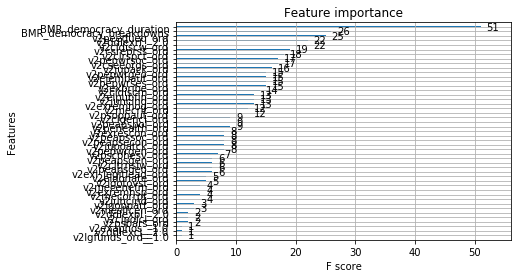

In [52]:
xgb.plot_importance(clf)

### Sorted version

In [237]:
srt_xgb_clf = RandomizedSearchCV(clf, param_grid, n_iter=20,
                            n_jobs=2, verbose=1, cv=tscv,
                            scoring='accuracy', refit=True, random_state=42)
print("Randomized search..")
search_time_start = time.time()
srt_xgb_clf.fit(srt_X_train, srt_y_train)
print("Randomized search time:", time.time() - search_time_start, "seconds")

Randomized search..
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   20.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   40.7s finished


Randomized search time: 41.85771417617798 seconds


In [238]:
print('Best hyperparameter setting for Bootsting is {}'.format(srt_xgb_clf.best_params_))
print('5-fold accuracy score is {:.3f}'.format(srt_xgb_clf.best_score_))

Best hyperparameter setting for Bootsting is {'subsample': 0.5, 'silent': True, 'scale_pos_weight': 7, 'reg_lambda': 0.1, 'n_estimators': 500, 'min_child_weight': 1.0, 'max_depth': 20, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.4}
5-fold accuracy score is 0.962


In [239]:
# Best estimator selected by randomized search
srt_best_xgb = srt_xgb_clf.best_estimator_

In [240]:
srt_best_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.4,
       colsample_bytree=0.6, gamma=0.5, learning_rate=0.2,
       max_delta_step=0, max_depth=20, min_child_weight=1.0, missing=None,
       n_estimators=500, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=0.1, scale_pos_weight=7, seed=None, silent=True,
       subsample=0.5)

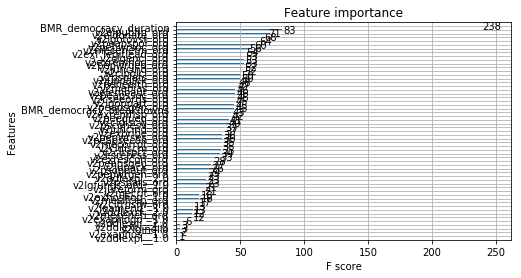

In [241]:
xgb.plot_importance(srt_best_xgb)

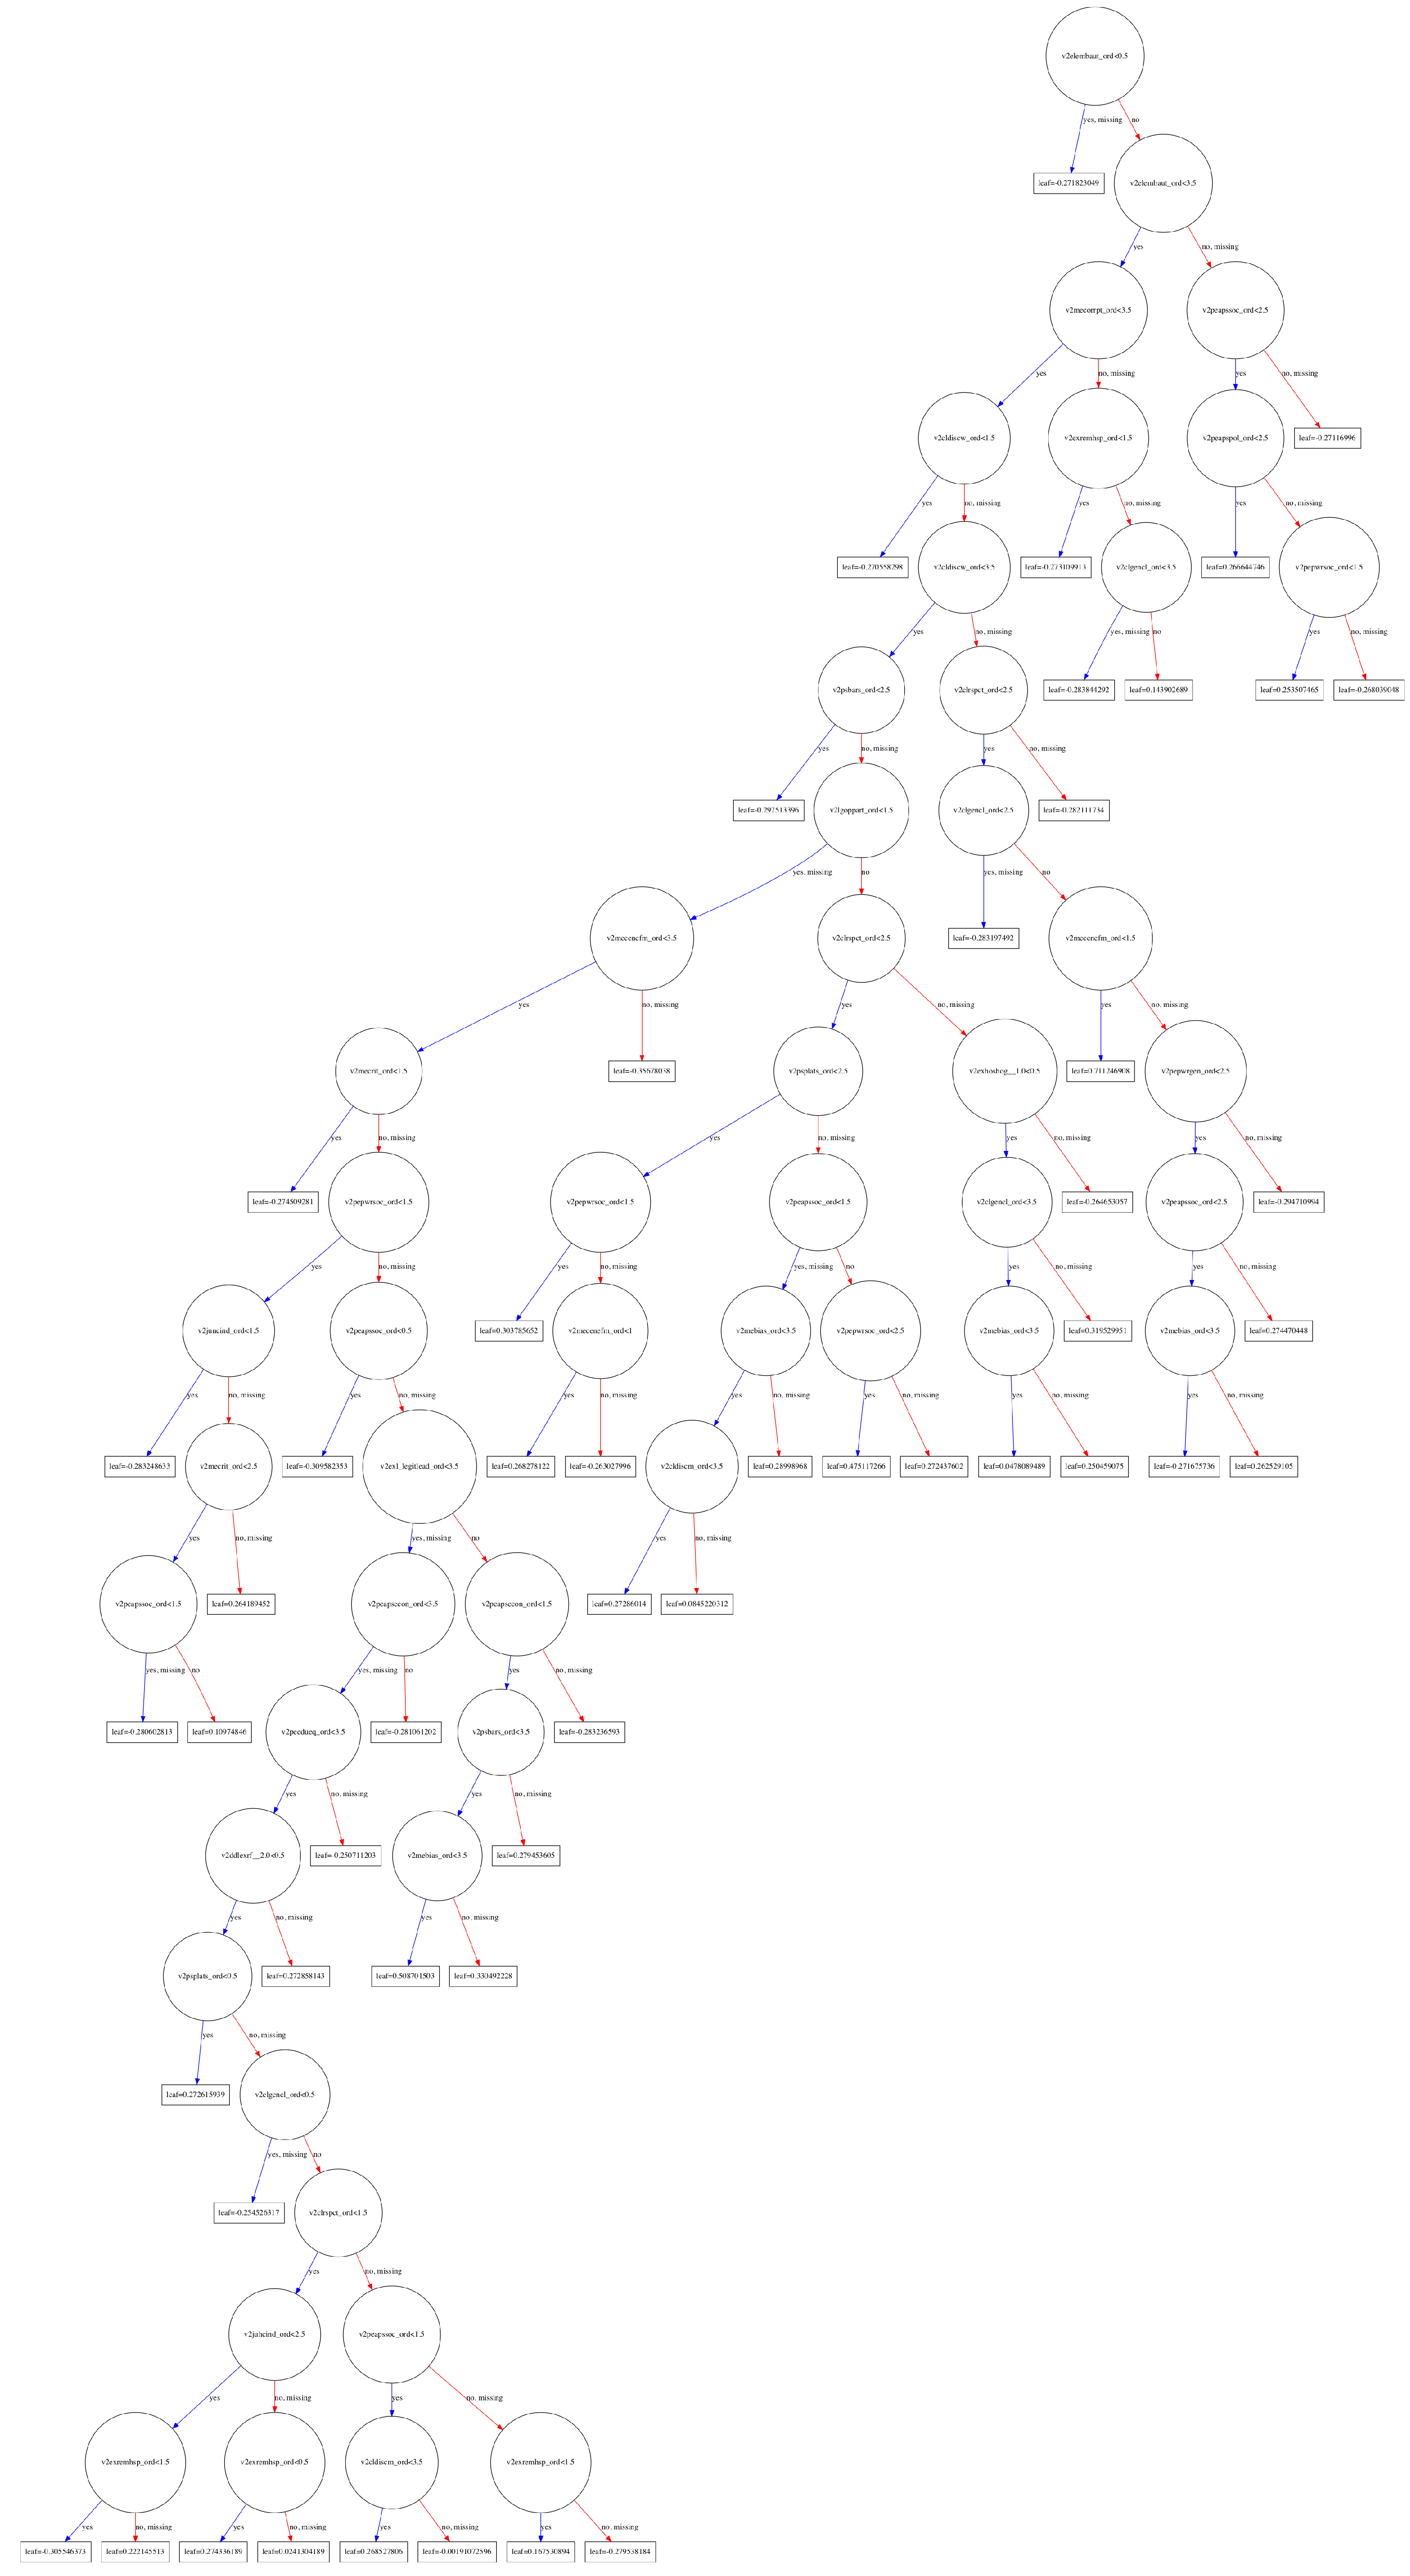

In [245]:
# https://github.com/dmlc/xgboost/issues/1725
xgb.plot_tree(srt_best_xgb, num_trees=3)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png', transparent=True)
plt.show()

### Evaluate against the test set

In [110]:
final_model = srt_xgb_clf.best_estimator_

In [112]:
final_model.fit(srt_X_train, srt_y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=15, min_child_weight=0.5, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.0, scale_pos_weight=7, seed=None,
       silent=True, subsample=0.9)

In [113]:
y_pred = clf.predict(srt_X_test)

In [114]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8038990825688074

In [119]:
len(y_test)

872

In [120]:
len(y_pred)

872

In [116]:
accuracy_score(y_test, np.zeros(len(y_pred)))

0.8784403669724771

#### Inpterpreting the final model

In [134]:
# fillNAs (get aroud the interpreter by treating missing values as one category = -1)
interpret_df = srt_X_train.fillna(-1)

In [138]:
# fit the best model
srt_best_xgb.fit(interpret_df.values, srt_y_train.values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=15, min_child_weight=0.5, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.0, scale_pos_weight=7, seed=None,
       silent=True, subsample=0.9)

In [139]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

In [140]:
SEED = 1
ITERS = 100

In [141]:
all_imp_feat_per_iter = {}
top_ten_per_iter = {}
imp_feat_counts = {}

In [142]:
list(srt_X_train.columns)

['v2csreprss_ord',
 'v2lgamend__1.0',
 'v2cldiscm_ord',
 'v2mebias_ord',
 'v2pepwrsoc_ord',
 'v2elpubfin_ord',
 'v2lginello',
 'v2clgencl_ord',
 'v2jureview_ord',
 'v2exl_legitlead_ord',
 'v2lgfunds_ord__1.0',
 'v2ddlexrf__1.0',
 'v2exrescon_ord',
 'v2peapsgeo_ord',
 'v2psbars_ord',
 'v2peapsecon_ord',
 'v2pepwrgeo_ord',
 'v2peapspol_ord',
 'BMR_democracy_duration',
 'v2ddlexci__2.0',
 'v2mecenefi_ord',
 'v2pehealth_ord',
 'v2ddlexci__1.0',
 'v2ddlexrf__2.0',
 'v2exremhsp_ord',
 'v2cseeorgs_ord',
 'v2lgoppart_ord',
 'v2jupoatck_ord',
 'v2peedueq_ord',
 'v2cldiscw_ord',
 'v2pscohesv_ord',
 'v2exaphos__1.0',
 'v2lgotovst_ord',
 'v2cltrnslw_ord',
 'v2meslfcen_ord',
 'v2eldonate_ord',
 'v2jupack_ord',
 'v2exhoshog__1.0',
 'v2psplats_ord',
 'v2ddlexpl__1.0',
 'v2clrspct_ord',
 'v2ddlexpl__2.0',
 'v2peapssoc_ord',
 'v2clpolcl_ord',
 'BMR_democracy_breakdowns',
 'v2pepwrgen_ord',
 'v2peapsgen_ord',
 'v2juncind_ord',
 'v2mecenefm_ord',
 'v2mecrit_ord',
 'v2elembaut_ord',
 'v2exremhog_ord',
 'v

In [143]:
time_start = time.time()
for i in range(ITERS):
    np.random.seed(SEED)
    print("iteration {}; Seed {}".format(i, SEED))
    interpreter = Interpretation(interpret_df.values, feature_names=list(srt_X_train.columns))
    model = InMemoryModel(srt_best_xgb.predict_proba, examples=interpret_df.values, unique_values=[0, 1])
    important_features = interpreter.feature_importance.feature_importance(model, ascending=False, progressbar=False)
    sorted_importance = important_features.sort_values(ascending=False)
    #print(sorted_importance)
    all_imp_feat_per_iter[str(i + 1)] = sorted_importance
    
    # top ten features
    top_ten = sorted_importance[:10]
    top_ten_per_iter[str(i + 1)] = top_ten
    
    # keep track of counts per feature which appear in top ten
    for ind, val in top_ten.iteritems():
        imp_feat_counts[ind] = imp_feat_counts.get(ind, 0) + 1
    
    # increment the seed
    SEED += 1
print("100 iterations time elapsed:", time.time() - search_time_start, "seconds")

iteration 0; Seed 1
iteration 1; Seed 2
iteration 2; Seed 3
iteration 3; Seed 4
iteration 4; Seed 5
iteration 5; Seed 6
iteration 6; Seed 7
iteration 7; Seed 8
iteration 8; Seed 9
iteration 9; Seed 10
iteration 10; Seed 11
iteration 11; Seed 12
iteration 12; Seed 13
iteration 13; Seed 14
iteration 14; Seed 15
iteration 15; Seed 16
iteration 16; Seed 17
iteration 17; Seed 18
iteration 18; Seed 19
iteration 19; Seed 20
iteration 20; Seed 21
iteration 21; Seed 22
iteration 22; Seed 23
iteration 23; Seed 24
iteration 24; Seed 25
iteration 25; Seed 26
iteration 26; Seed 27
iteration 27; Seed 28
iteration 28; Seed 29
iteration 29; Seed 30
iteration 30; Seed 31
iteration 31; Seed 32
iteration 32; Seed 33
iteration 33; Seed 34
iteration 34; Seed 35
iteration 35; Seed 36
iteration 36; Seed 37
iteration 37; Seed 38
iteration 38; Seed 39
iteration 39; Seed 40
iteration 40; Seed 41
iteration 41; Seed 42
iteration 42; Seed 43
iteration 43; Seed 44
iteration 44; Seed 45
iteration 45; Seed 46
iterati

In [144]:
#top_ten_per_iter
imp_feat_counts

{'BMR_democracy_duration': 100,
 'v2ddlexrf__2.0': 100,
 'v2clrspct_ord': 100,
 'v2exbribe_ord': 100,
 'v2peedueq_ord': 100,
 'v2elembaut_ord': 100,
 'v2psoppaut_ord': 90,
 'v2pscohesv_ord': 72,
 'v2pepwrgen_ord': 61,
 'v2elpubfin_ord': 77,
 'v2cldiscw_ord': 42,
 'v2cldiscm_ord': 56,
 'v2jupoatck_ord': 1,
 'v2pepwrsoc_ord': 1}

In [145]:
# plot frequency of important features
feat_series = pd.Series(imp_feat_counts)
feat_series = feat_series.sort_values(ascending=True)

In [150]:
y_labels = ["Election Management Body's autonomy",
 "Educational equality",
 "Executive bribery and corrupt exchanges",
 "Rigorous and impartial public administration",
 "Referendums permitted",
 "Democracy duration",
 "Opposition parties autonomy",
 "Public campaign finance",
 "Legislative party cohesion",
 "Equality: Power distributed by gender",
 "Freedom of discussion for men",
 "Freedom of discussion for women",
 "Equality: Power distributed by social group",
 "Government attacks on judiciary"]

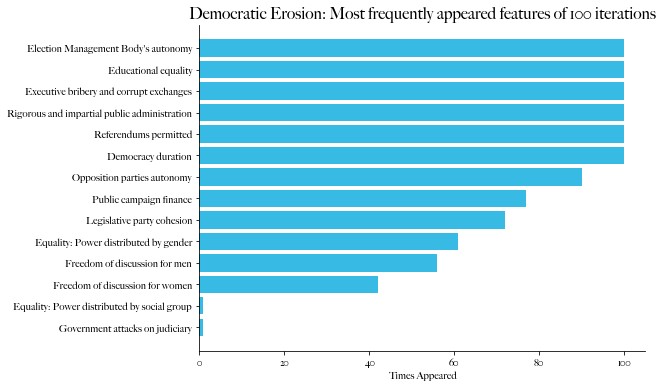

In [249]:
plt.figure(figsize=(8, 6))
plt.barh(np.arange(len(feat_series)), feat_series.values, color='#37bbe4')
plt.yticks(np.arange(len(feat_series)), reversed(y_labels), fontfamily='Big Caslon')
plt.xticks(fontfamily='Big Caslon')
plt.xlabel('Times Appeared', fontfamily='Big Caslon')
sns.despine()
plt.title('Democratic Erosion: Most frequently appeared features of 100 iterations', fontname='Big Caslon', fontsize=16)
plt.savefig('freq_features.png', dpi=300, transparent=True, bbox_inches='tight')

In [231]:
sns.set(style="white")
np.random.seed(SEED)

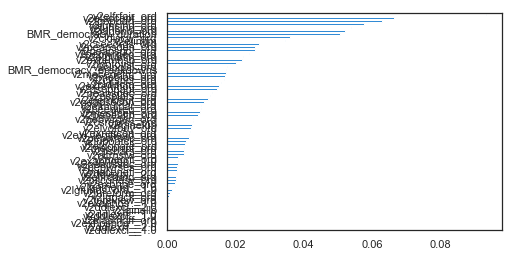

In [232]:
interpreter = Interpretation(cleaned_X, feature_names=indep_vars_list)
model = InMemoryModel(rf_erosion.predict_proba, examples=cleaned_X, unique_values=[0, 1])
plots = interpreter.feature_importance.plot_feature_importance(model, ascending=True, progressbar=False)
important_features = interpreter.feature_importance.feature_importance(model, ascending=False, progressbar=False)

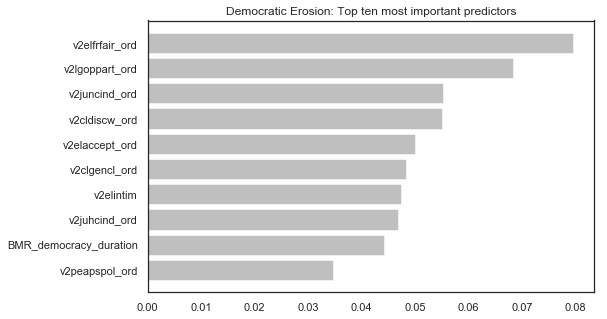

In [233]:
top_ten = important_features[:10]
plt.figure(figsize=(8, 5))
sorted_top_ten = top_ten.sort_values(ascending=True)
plt.barh(np.arange(10), sorted_top_ten.values, color='grey', alpha=0.5)
plt.yticks(np.arange(10), sorted_top_ten.index)
plt.title('Democratic Erosion: Top ten most important predictors')
plt.savefig('fh_importance_de.png', bbox_inches='tight')

([<matplotlib.axis.YTick at 0x1a205f8c18>,
 <a list of 10 Text yticklabel objects>)

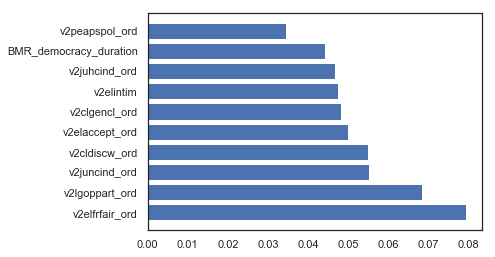

In [176]:
top_ten = important_features[:10]
plt.barh(np.arange(10), top_ten.values)
plt.yticks(np.arange(10), top_ten.index)

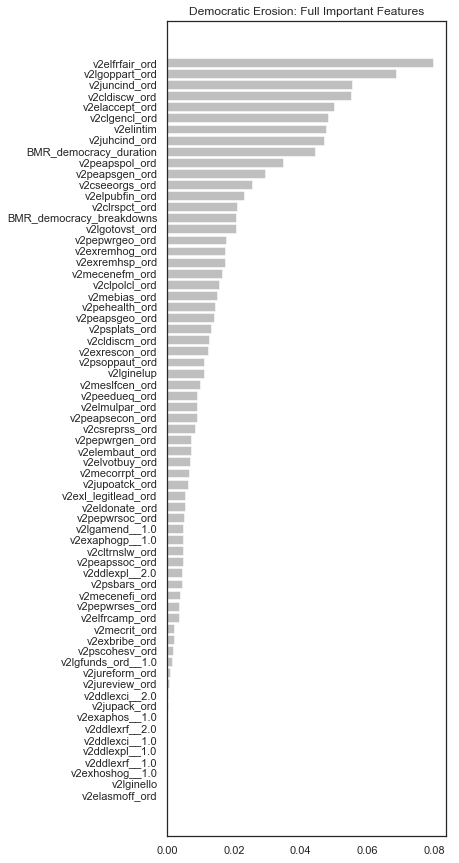

In [234]:
sorted_importance = important_features.sort_values(ascending=True)
plt.figure(figsize=(5,15))
plt.barh(np.arange(len(sorted_importance)), sorted_importance.values, color='grey', alpha=0.5)
plt.yticks(np.arange(0,len(indep_vars_list)), list(sorted_importance.index))
plt.title('Democratic Erosion: Full Important Features')
plt.savefig('de_full_importance.png', bbox_inches='tight')

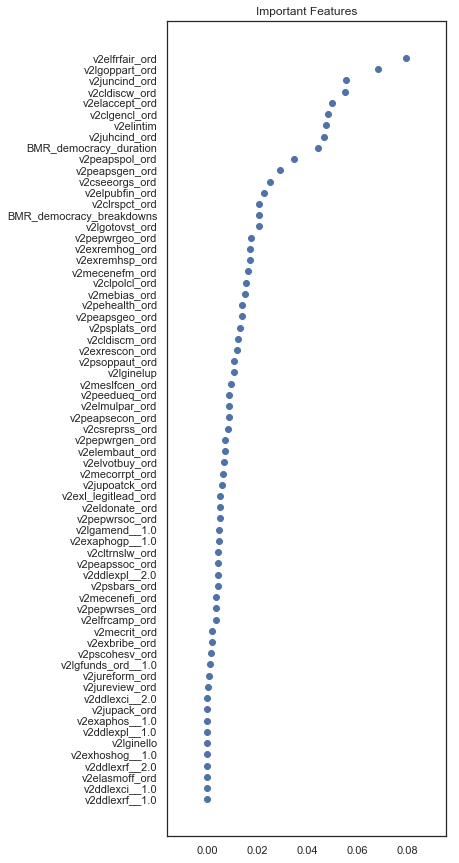

In [177]:
sorted_importance = important_features.sort_values(ascending=True)
plt.figure(figsize=(5,15))
plt.scatter(sorted_importance, np.arange(0,len(indep_vars_list)))
_ = plt.yticks(np.arange(0,len(indep_vars_list)), list(sorted_importance.index))
_ = plt.title('Important Features')

In [178]:
top_five = important_features[:5]
top_five

v2elfrfair_ord    0.079525
v2lgoppart_ord    0.068401
v2juncind_ord     0.055322
v2cldiscw_ord     0.055035
v2elaccept_ord    0.049955
dtype: float64